# General Linear Models in Julia: Iris Study Case

In [36]:
using DataFrames, DataArrays, DataFramesMeta, RDatasets
using GLM
using Gadfly

## Load Data

In [21]:
iris = dataset("datasets", "iris");

## Data Description

In [34]:
showcols(iris)

150x5 DataFrames.DataFrame
| Col # | Name        | Eltype      | Missing |
|-------|-------------|-------------|---------|
| 1     | SepalLength | Float64     | 0       |
| 2     | SepalWidth  | Float64     | 0       |
| 3     | PetalLength | Float64     | 0       |
| 4     | PetalWidth  | Float64     | 0       |
| 5     | Species     | ASCIIString | 0       |

In [35]:
head(iris)

,SepalLength,SepalWidth,PetalLength,PetalWidth,Species
1,5.1,3.5,1.4,0.2,setosa
2,4.9,3.0,1.4,0.2,setosa
3,4.7,3.2,1.3,0.2,setosa
4,4.6,3.1,1.5,0.2,setosa
5,5.0,3.6,1.4,0.2,setosa
6,5.4,3.9,1.7,0.4,setosa


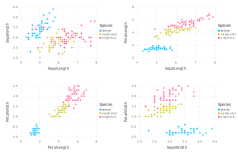

In [16]:
p1 = plot(iris, x="SepalLength", y="SepalWidth", color="Species")
p2 = plot(iris, x="PetalLength", y="PetalWidth", color="Species")
p3 = plot(iris, x="SepalLength", y="PetalLength", color="Species")
p4 = plot(iris, x="SepalWidth", y="PetalWidth", color="Species")
p = hstack(vstack(p1, p2), vstack(p3, p4))
draw(SVGJS(900px, 600px), p)

## Rename Explanatory and Dependent Variables

In [37]:
df = copy(iris)
rename!(df, :SepalLength, :x1)
rename!(df, :SepalWidth, :x2)
rename!(df, :PetalLength, :x3)
rename!(df, :PetalWidth, :x4)
rename!(df, :Species, :y);

## Preprocess Data

Lets separate the data to identify each class individualy with a binary model.

In [233]:
df_y1 = copy(df)
df_y2 = copy(df)
df_y3 = copy(df)

df_y1[:y] = DataArray{Int8}(df_y1[:y] .== "setosa")
df_y2[:y] = DataArray{Int8}(df_y2[:y] .== "versicolor")
df_y3[:y] = DataArray{Int8}(df_y3[:y] .== "virginica")

df_y1[:x1] = df_y1[:x1]/maximum(df_y1[:x1]);
df_y1[:x2] = df_y1[:x2]/maximum(df_y1[:x2]);
df_y1[:x3] = df_y1[:x3]/maximum(df_y1[:x3]);
df_y1[:x4] = df_y1[:x4]/maximum(df_y1[:x4]);

### Auxiliary Functions

In [284]:
fit_model(df, formula) = glm(formula, df, Binomial())
function fit_models(df, formulas)
    lms = []
    for formula in formulas
        try
            lm = fit_model(df, formula)
            push!(lms, lm)
        catch LoadError
        end
    end
    return lms
end

function evaluate_bin(df, lm)
    y_pred = map(y -> y > .5? 1 : 0, predict(lm))
    y_real = df[:y]
    
    acc = sum(DataArray{Int8}(y_pred - y_real .== 0))/length(y_real)
    println("Acc: $acc")
    return y_pred
end

function evaluate(df, lms)
    y_real = df[:y]
    y_preds = Array[predict(lm) for lm in lms]
    y_pred = []
    for i = 1:length(y_real)
        values = map(y -> y[i], y_preds)
        max_value = maximum(values)
        push!(y_pred, findin(values, max_value)[1])
    end
    acc = sum(DataArray{Int8}(y_pred - y_real .== 0))/length(y_real)
    println("Acc: $acc")
    return y_pred
end

function confusion_matrix(y_real, y_pred)
    size = max(length(Set(y_real)), length(Set(y_pred)))
    matrix = fill(0, (size, size))
    for i=1:length(y_real)
        matrix[y_real[i], y_pred[i]] += 1
    end
    println("Confusion Matrix:\n$matrix")
    return matrix
end

confusion_matrix (generic function with 1 method)

## Simple Regression Analysis

### Analysis Setosa Class

Define the first-order models:

In [267]:
formulas = [y ~ x1, y ~ x2, y ~ x3, y  ~ x4]

4-element Array{DataFrames.Formula,1}:
 Formula: y ~ x1
 Formula: y ~ x2
 Formula: y ~ x3
 Formula: y ~ x4

### Fit Model and Evaluate for Y = Setosa

In [268]:
lms = fit_models(df_y1, formulas);

In [272]:
map(lm -> evaluate_bin(df_y1, lm), lms);

Acc: 0.3333333333333333
Acc: 0.3333333333333333


### Fit Model and Evaluate for Y = Versicolor

In [150]:
lms = fit_models(df_y2, formulas);

In [151]:
map(lm -> evaluate_bin(df_y1, lm), lms)

4-element Array{Any,1}:
 0.666667
 0.46    
 0.646667
 0.666667

### Fit Model and Evaluate for Y = Virginica

In [152]:
lms = fit_models(df_y3, formulas);

In [193]:
map(lm -> evaluate_bin(df_y3, lm), lms)

4-element Array{Any,1}:
 0.82    
 0.66    
 0.953333
 0.96    

### Final Simple Regression Model Y → [:Setosa, :Versicolor, :Virginica]

In [194]:
lms = fit_models(df_y1, formulas)[1], fit_models(df_y2, formulas)[1], fit_models(df_y3, formulas)[4];
df_y = copy(df)
df_y[:y] = df_y1[:y] + df_y2[:y]*2 + df_y3[:y]*3
evaluate(df_y, lms)

Acc: 0.8466666666666667


## Multiple Regression Analysis

In [195]:
formulas = [y ~ x1 + x2, y ~ x1 + x3, y ~ x1 + x4, y  ~ x2 + x3, y ~ x2 + x4, y ~ x3 + x4, 
            y ~ x1 + x2 + x3, y ~ x2 + x3 + x4, y ~ x1 + x3 + x4, y ~ x1 + x2 + x3 + x4]

10-element Array{DataFrames.Formula,1}:
 Formula: y ~ x1 + x2          
 Formula: y ~ x1 + x3          
 Formula: y ~ x1 + x4          
 Formula: y ~ x2 + x3          
 Formula: y ~ x2 + x4          
 Formula: y ~ x3 + x4          
 Formula: y ~ x1 + x2 + x3     
 Formula: y ~ x2 + x3 + x4     
 Formula: y ~ x1 + x3 + x4     
 Formula: y ~ x1 + x2 + x3 + x4

In [198]:
lms = fit_models(df_y1, formulas)
map(lm -> evaluate_bin(df_y1, lm), lms)

lms = fit_models(df_y2, formulas)
map(lm -> evaluate_bin(df_y2, lm), lms)

lms = fit_models(df_y3, formulas)
map(lm -> evaluate_bin(df_y3, lm), lms)

Any[]
Any[0.7133333333333334,0.62,0.6666666666666666,0.7266666666666667,0.7266666666666667,0.64,0.72,0.7466666666666667,0.7133333333333334,0.74]
Any[0.8066666666666666,0.9666666666666667,0.96,0.9533333333333334,0.9533333333333334,0.96,0.9666666666666667,0.98,0.98,0.9866666666666667]


### Final Multiple Regression Model Y → [:Setosa, :Versicolor, :Virginica]

Selection of the best models that fitted in simple and multiple regression analysis.

In [285]:
f1 = y ~ x1
f2 = y ~ x2 + x3 + x4
f3 = y ~ x1 + x2 + x3 + x4
lm1 = fit_model(df_y1, f1)
lm2 = fit_model(df_y2, f2)
lm3 = fit_model(df_y3, f3)
y_pred = evaluate(df_y, [lm1, lm2, lm3])
confusion_matrix(df_y[:y], y_pred);

Acc: 0.94
Confusion Matrix:
[50 0 0
 5 43 2
 1 1 48]
